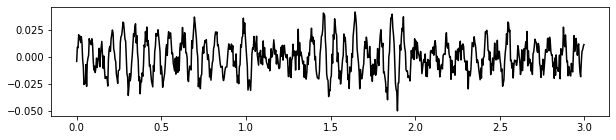

In [1]:
import emd
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define and simulate a simple signal
peak_freq = 15
sample_rate = 256
seconds = 10
noise_std = .4
x = emd.simulate.ar_oscillator(peak_freq, sample_rate, seconds,
                               noise_std=noise_std, random_seed=42, r=.96)[:, 0]
x = x*1e-4
t = np.linspace(0, seconds, seconds*sample_rate)

# sphinx_gallery_thumbnail_number = 6


# Plot the first 5 seconds of data
plt.figure(figsize=(10, 2))
plt.plot(t[:sample_rate*3], x[:sample_rate*3], 'k')

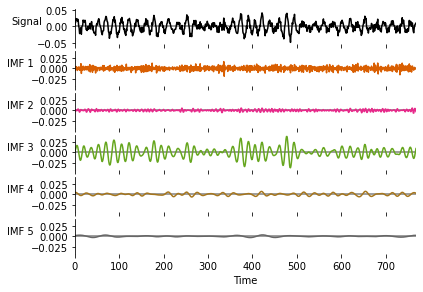

In [2]:
# Run a mask sift
imf = emd.sift.mask_sift(x, max_imfs=5)

emd.plotting.plot_imfs(imf[:sample_rate*3, :], cmap=True, scale_y=True)

In [25]:
imf

array([[-0.00441886, -0.00299449,  0.00078106,  0.00467678,  0.00171865],
       [ 0.00341293, -0.00120061,  0.00385921,  0.00484531,  0.00186112],
       [-0.00332756,  0.00084908,  0.00789466,  0.00481503,  0.00199968],
       ...,
       [-0.00716772,  0.00771497, -0.01203178, -0.00573314, -0.00151761],
       [-0.0076514 ,  0.00823792, -0.0103226 , -0.00603544, -0.00146634],
       [ 0.0157475 ,  0.00710914, -0.00905304, -0.00599037, -0.00140457]])

In [3]:
# Compute frequency statistics
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

Text(0.5, 0, 'Frequency (Hz)')

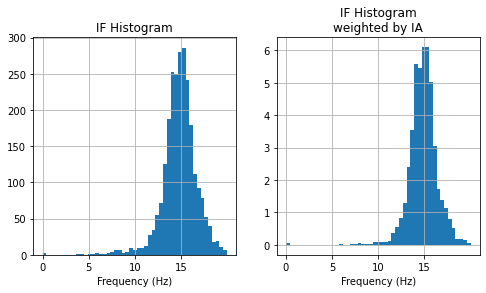

In [4]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
# Plot a simple histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, 20))
plt.grid(True)
plt.title('IF Histogram')
plt.xticks(np.arange(0, 20, 5))
plt.xlabel('Frequency (Hz)')

plt.subplot(122)
# Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, 20), weights=IA[:, 2])
plt.grid(True)
plt.title('IF Histogram\nweighted by IA')
plt.xticks(np.arange(0, 20, 5))
plt.xlabel('Frequency (Hz)')

In [5]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 5, 4)
print('Bin Edges:   {0}'.format(freq_edges))
print('Bin Centres: {0}'.format(freq_centres))

Bin Edges:   [1. 2. 3. 4. 5.]
Bin Centres: [1.5 2.5 3.5 4.5]


In [6]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 50, 8, 'log')

# We round the values to 3dp for easier visualisation
print('Bin Edges:   {0}'.format(np.round(freq_edges, 3)))
print('Bin Centres: {0}'.format(np.round(freq_centres, 3)))

Bin Edges:   [ 1.     1.631  2.659  4.336  7.071 11.531 18.803 30.662 50.   ]
Bin Centres: [ 1.315  2.145  3.498  5.704  9.301 15.167 24.732 40.331]


In [7]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 50, 8, 'log')
f, spectrum = emd.spectra.hilberthuang(IF, IA, freq_edges)

In [8]:
f, spectrum = emd.spectra.hilberthuang(IF, IA, (1, 50, 25))

In [33]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 100, 128, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

In [36]:
spec_weighted.shape
freq_centres.shape

(128,)

ValueError: x and y must have same first dimension, but have shapes (24,) and (128, 5)

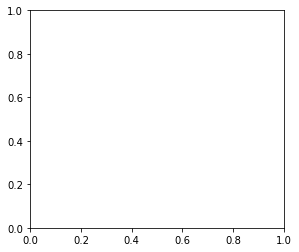

In [49]:
plt.figure(figsize=(10, 4))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
plt.xticks(np.arange(10)*10)
plt.xlim(0, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(10)*10)
plt.xlim(0, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)

In [50]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24, 'linear')

f, hht = emd.spectra.hilberthuang(IF[:, 2, None], IA[:, 2, None], freq_edges, mode='amplitude', sum_time=False)
time_centres = np.arange(201)-.5

Text(0, 0.5, 'Frequency (Hz)')

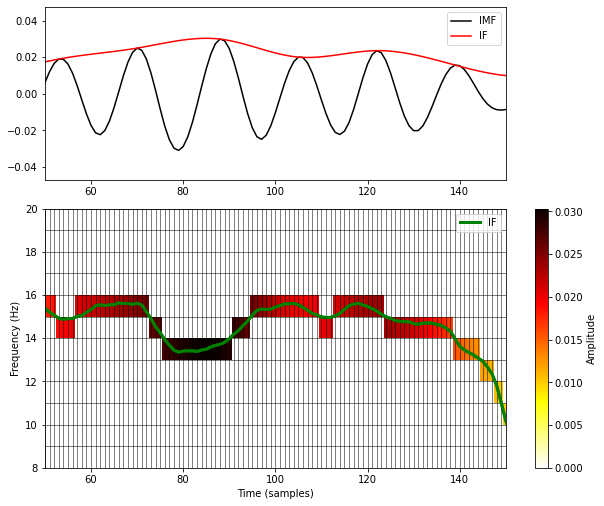

In [53]:
plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(50, 150)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])
plt.plot(IF[:, 2], 'g', linewidth=3)
plt.legend(['IF'])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :200], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Add some grid lines
for ii in range(len(freq_edges)):
    plt.plot((0, 200), (freq_edges[ii], freq_edges[ii]), 'k', linewidth=.5)
for ii in range(200):
    plt.plot((ii, ii), (0, 20), 'k', linewidth=.5)

# Overlay the IF again for better visualisation
plt.plot(IF[:, 2], 'g', linewidth=3)

# Set lims and labels
plt.xlim(50, 150)
plt.ylim(8, 20)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')


Text(0, 0.5, 'Frequency (Hz)')

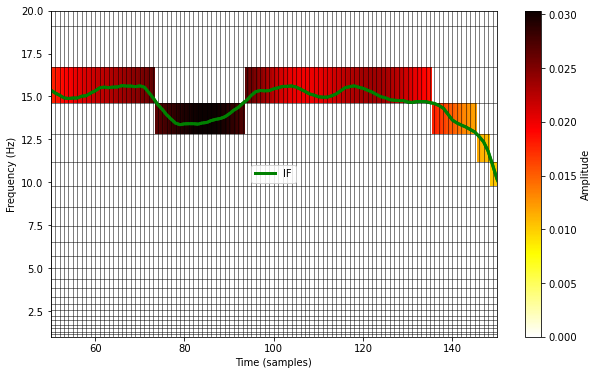

In [55]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24, 'log')

f, hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude', sum_time=False)
time_centres = np.arange(201)-.5

plt.figure(figsize=(10, 6))
plt.plot(IF[:, 2], 'g', linewidth=3)
plt.legend(['IF'])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :200], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Add some grid lines
for ii in range(len(freq_edges)):
    plt.plot((0, 200), (freq_edges[ii], freq_edges[ii]), 'k', linewidth=.5)
for ii in range(200):
    plt.plot((ii, ii), (0, 20), 'k', linewidth=.5)

# Overlay the IF again for better visualisation
plt.plot(IF[:, 2], 'g', linewidth=3)

# Set lims and labels
plt.xlim(50, 150)
plt.ylim(1, 20)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

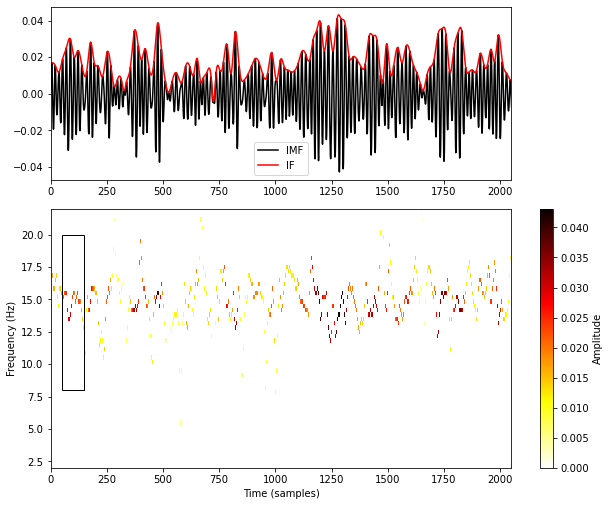

In [16]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*3, 'linear')

f, hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude', sum_time=False)
time_centres = np.arange(2051)-.5

plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(0, 2050)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :2050], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Set lims and labels
plt.xlim(0, 2050)
plt.ylim(2, 22)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

rect = patches.Rectangle((50, 8), 100, 12, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)


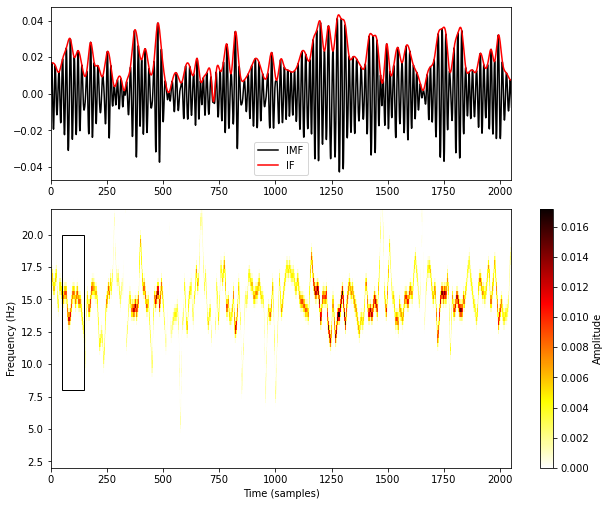

In [60]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*3, 'linear')

f, hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude', sum_time=False)
time_centres = np.arange(2051)-.5

# Apply smoothing
hht = ndimage.gaussian_filter(hht, 1)

plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(0, 2050)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :2050], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Set lims and labels
plt.xlim(0, 2050)
plt.ylim(2, 22)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

rect = patches.Rectangle((50, 8), 100, 12, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)

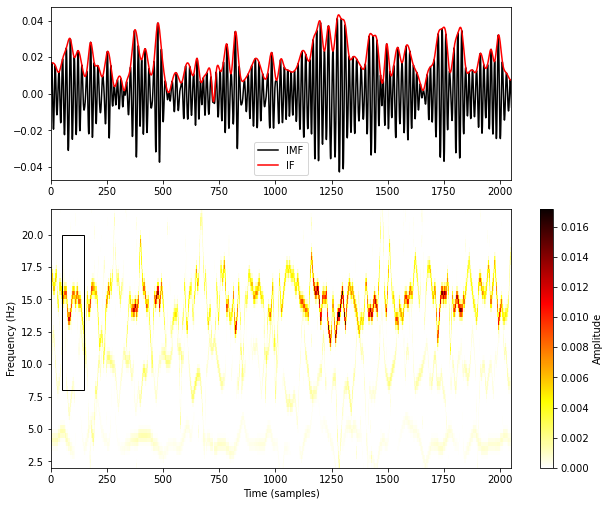

In [61]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*3, 'linear')

f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=False)
time_centres = np.arange(2051)-.5

# Apply smoothing
hht = ndimage.gaussian_filter(hht, 1)

plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(0, 2050)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :2050], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Set lims and labels
plt.xlim(0, 2050)
plt.ylim(2, 22)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

rect = patches.Rectangle((50, 8), 100, 12, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

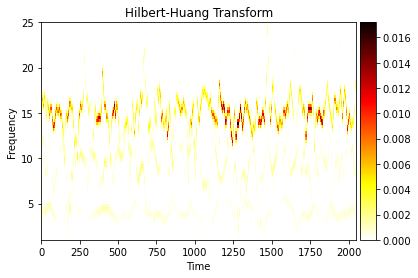

In [62]:
emd.plotting.plot_hilberthuang(hht, time_centres, freq_centres)

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

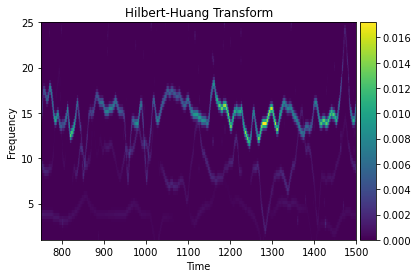

In [63]:
emd.plotting.plot_hilberthuang(hht, time_centres, freq_centres,
                               cmap='viridis', time_lims=(750, 1500),  log_y=False)